# advent of code

https://adventofcode.com/settings

(login with github)

running with lewagon envtry finding cookie by going to developer tools > storage

to download input via request need cookies!

try finding cookie by going to developer tools > storage

session:"53616c7465645f5f0d9c485692603b4bf39627d657a461b73296c03ea325a9d793cf86d14e1e4c575ad96e8f53ebf8965a3fa1b9b44a87cb4102ed29f5b64e0c"

apparently they are stored in sqlite file in Profile folder (/home/svetlana/snap/firefox/common/.mozilla/firefox/1p0df6c0.default/)

In [1]:
import time
import numpy as np
import pandas as pd
import re
import copy


import matplotlib.pyplot as plt

### day 1

Task sum of two-digit numbers in each line which are first and last digit 

If only one digit, then double it (99 for the first)

Ideally I would use np.vectorize on extraction function and an array of type object

In [4]:
# 1
with open('input_01', 'r') as f:
    #print(f.readlines()) #this will keep \n
    mylist = f.read().splitlines() # no \n

In [24]:
%time
# brute force (list of lists, nested for loop = bad!)
def get_sum_day1(list_of_strings):
    num_list = []
    for line in list_of_strings:
        num=[d for d in line if d.isdigit()]
        num_list.append(int(num[0]+num[-1]))
    return num_list

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 17.4 µs


In [25]:
np.sum(get_sum_day1(mylist))

53921

Now we need to also get spelled out numbers like two, three, ...

There is python lib num2words (it even has ordinals) but by simply Ctrl F I conclude that my input only has one to nine.

In [26]:
# now need for dictionary replacement
word2num = {
     'one':'1'
    ,'two':'2'
    ,'three':'3'
    ,'four':'4'
    ,'five':'5'
    ,'six':'6'
    ,'seven':'7'
    ,'eight':'8'
    ,'nine':'9'
}

In [30]:
#mylist[0].translate(word2num)
# brute force 2
mylist2 = [d.replace(word,num) for word, num in word2num.items() for d in mylist]


In [32]:
np.sum(get_sum_day1(mylist2)) #485079 is too high though...

485079

check https://www.reddit.com/r/adventofcode/ for hints:

apparently the words can overlap! 'twone' should give 21....

In [72]:
import re
matches = re.finditer('(?=two)|(?=one)','twone')
for match in matches:
    print( match)

<re.Match object; span=(0, 0), match=''>
<re.Match object; span=(2, 2), match=''>


### day 2

Determine which games would have been possible if the bag had been loaded with only 12 red cubes, 13 green cubes, and 14 blue cubes. What is the sum of the IDs of those games?



In [2]:
with open('input_02', 'r') as f:
    str_list = f.read().splitlines()

In [3]:
str_list[0]

'Game 1: 4 red, 8 green; 8 green, 6 red; 13 red, 8 green; 2 blue, 4 red, 4 green'

In [21]:
# store ids which are valid
game_ids = []

# store constraints
constraints = {'red':12, 'green':13, 'blue':14}

def check_draw(draw, constraints=constraints):
    """
    take draw as string and optional constraint dict
    check against constraint if draw is valid or not
    return bool
    """
    # make a dict color:number for the draw
    draw_dic = {col.split()[1]:int(col.split()[0]) for col in draw.split(', ')}
    # compare to constraint
    valid = all([draw_dic[k] <= constraints[k] for k in draw_dic.keys()])
    return valid

# loop over games
for game_str in str_list:
    id, game = game_str.split(': ')
    #convert id to int
    id = int(id.strip('Game '))
    #split game inot draws
    draws = game.split('; ')
    # store game id only if all draws are valid
    if all([check_draw(draw) for draw in draws]):
        game_ids.append(id)

In [24]:
np.sum(game_ids) #answer

3099

### day3

--- Day 3: Gear Ratios ---

You and the Elf eventually reach a gondola lift station; he says the gondola lift will take you up to the water source, but this is as far as he can bring you. You go inside.

It doesn't take long to find the gondolas, but there seems to be a problem: they're not moving.

"Aaah!"

You turn around to see a slightly-greasy Elf with a wrench and a look of surprise. "Sorry, I wasn't expecting anyone! The gondola lift isn't working right now; it'll still be a while before I can fix it." You offer to help.

The engineer explains that an engine part seems to be missing from the engine, but nobody can figure out which one. If you can add up all the part numbers in the engine schematic, it should be easy to work out which part is missing.

The engine schematic (your puzzle input) consists of a visual representation of the engine. There are lots of numbers and symbols you don't really understand, but apparently any number adjacent to a symbol, even diagonally, is a "part number" and should be included in your sum. (Periods (.) do not count as a symbol.)

Here is an example engine schematic:

467..114..
...*......
..35..633.
......#...
617*......
.....+.58.
..592.....
......755.
...$.*....
.664.598..

In this schematic, two numbers are not part numbers because they are not adjacent to a symbol: 114 (top right) and 58 (middle right). Every other number is adjacent to a symbol and so is a part number; their sum is 4361.

Of course, the actual engine schematic is much larger. What is the sum of all of the part numbers in the engine schematic?


In [2]:
#with open ('input_03_example','r') as f:
with open ('input_03','r') as f:
    inp = f.read().splitlines()

In [13]:
inp

['..............423....688..934............970................................95.728..........896...113..................153..972.............',
 '...122..................*.....*..........................919..509*..........&...@.........../...........................+.......*...........',
 '....+..........259....698..373.992.52.674.........................781...22........130.584.....-...%399.......777.................266........',
 '......148..+....*........................*.....357.123.......................812.........*756.143...........*...............................',
 '..691*.....700..708................-...357........*........$177......%..244.............................762.453....477-.707..-168..359*.....',
 '.......................394.443....456......750..................71.160.....*..183.........835..74.........*.............../............129..',
 '....578$....................%........................362..1......*.......661....*...........=.....730......744..294..........247

In [9]:
# check if number is surrounded by dots completely
# constraints: edge and corner cases
def not_adjacent(s:int, e:int, l:int, inp=inp):
    """
    Inputs are indices of number start(s), end(e) and line(l)
    Return boolean : True if it is not adjacent to symbol (thus to <skick out)
    Basically checks if number is surrounded by dots<s"""
    last_index = len(inp[0])
    # right coordinates in slicing is always one more than single indexing
    left_coord = (s-1) if s>0 else s
    right_coord = (e+1) if e<last_index else e
    # define surrounding chars accounting for edge cases
    left = inp[l][s-1] if s>0 else ''
    right = inp[l][e] if e<last_index else ''
    # not so easy: top and bottom also change for edges
    top = inp[l-1][left_coord:right_coord] if l>0 else ''
    bottom = inp[l+1][left_coord:right_coord] if l<(len(inp)-1) else ''
    surrounding = left+right+top+bottom
    #print(f'{l} < {(len(inp)-1)} {l<(len(inp)-1)}')
    #print(f'bottom line: {inp[l+1]}')
    #print(f'bottom segment: {inp[l+1][(s-1):(e+1)]}')
    #print(f'line:{l},start:{s},end:{e},left:{left},right:{right},top:{top},bottom:{bottom}')

    #print(surrounding, set(surrounding)=={'.'})

    # return True if surroundings are all dots (use set for uniques)
    return set(surrounding)=={'.'}

In [10]:
# determine which are numbers and extract them
# determine which are only surrounded by dots (using indices) and discard them
#from curses.ascii import isdigit

coords={}


#list of match objects
for i in range(len(inp)): # for each line return tuple of start, end, match
    coords[i]=[(match.start(), match.end(), match.group()) for match in re.finditer('[0-9]+', inp[i])]

#coords

In [ ]:
# remove non adjacent numbers
for l in coords.keys(): #for each key = line number
    #print(f'key:{l},length of list:{len(coords[l])}')
    for t in coords[l]: #for each tuple in list
        #print(t)
        if not_adjacent(t[0],t[1],l, inp):
            #print(f'to remove: {t}')#.remove(t)
            coords[l].remove(t)
# remove empty lists
#coords

In [12]:
flat = sum(list(coords.values()),[]) # elegant flatten list
sum([int(t[2]) for t in flat]) # 547328 is too high :(
    # are there numbers touching on numbers? - nope.
    # so i am removing too little but it seems to work :/

547328

### day 4

each card has winning numbers | numbers you have

for matching each winning number you get 2^n points with n=0 for first etc.

In [1]:
with open('input_04','r') as f:
    cards = f.read().splitlines()

In [17]:
# list of powers of 2 which each card will be worth (minus 1 since 2^0=1)
powers = []
for card in cards:
    winning_num=card.split(': ')[1].split(' | ')[0].split()
    my_num=card.split(': ')[1].split(' | ')[1].split()
    power = len([num for num in my_num if num in winning_num])
    if power > 0:
        powers.append(power)

In [25]:
np.sum(2**((np.array(powers)-1))) #answer

24542

### day 6

boat races: you charge for specific amount of time and it allows you to travel with different speeds

1ms charging adds 1mm/ms speed

task: for each race, how many ways to beat current record are there? then multiply for answer.

In [36]:
Time=[58,     81,     96,     76]
Distance=[434,   1041,   2219,   1218]

In [37]:
# we just need a formula and plot it
# speed = charge_time
# time_to_travel = Time-charge_time
# distance_traveled = time_to_travel*speed = time_to_travel*charge_time=(Time-charge_time)*charge_time = Time*charge_time - charge_time**2

num_of_ways = []

for Time, Distance in zip(Time, Distance):
    distance_traveled = []
    # for all times to charge from 0 to max time
    for i in range(Time):
        distance_traveled.append((Time-i)*i)
    num_of_ways.append(np.sum(np.array(distance_traveled)>Distance))

In [40]:
np.prod(np.array(num_of_ways)) #answer

1159152

### day 7

need to rank card hands byspecific rules then multiply their bid by rank


In [4]:
cards = pd.read_csv('input_07', sep=' ', header=None)
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
# create rules for ranking

#len(set(list('AAAAA'))) # always remember: nunique() of a list is a set!

# this is like a custom sorting rule
# need: 1) custom sort (see chatGPT for assigning weights to cards)
# need: 2) classifier wrapping this up
# first order by class, within class by card weight

##### function to sort into class ######

from collections import Counter

# classes - assign them a number already - we have 7
def classify_hand(hand: str):
    """
    This function will determine relative weights of hands
    """
    # how many unique types?
    #cardinality = len(set(list(hand)))
    counts = Counter(list(hand))

    # highest: rank 7 (all cards same)
    #if cardinality==1:
    if 5 in counts.values():
        rank = 7

    # if we have 2 kinds of cards:
        # if 4 are same (4 of a kind)
    elif 4 in counts.values(): #cardinality==2:
        rank = 6
        # if 3 are same (full house)
    elif all(val in counts.values() for val in (2,3)):
        rank = 5

    # if we have 3 kinds of cards:
        # if 3 are the same (3 of a kind)
    elif 3 in counts.values():
        rank = 4
        # if there are 2 pairs
    elif list(counts.values()).count(2)==2:
        rank = 3

    # if we have 4 kinds it is basically always 1 pair right?
    elif list(counts.values()).count(2)==1:
        rank = 2

    # if we have 5 kinds
    elif list(counts.values())==[1]*5:
        rank = 1
    return rank

In [8]:
####### function to sort by card weight #######

# this is our custom card sorter from GPT
# this only works for single-character strings :(

def custom_card_sort(card):
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    # Assign weights based on the order
    rule = {card: weight for weight, card in enumerate(order)}
    return rule.get(card)


# https://stackoverflow.com/questions/52475458/how-to-sort-pandas-dataframe-with-a-key
# do it vectorized instead!
# must take series and return series

def custom_card_sort_pd(series):
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    # Assign weights based on the order
    rule = {card: weight for weight, card in enumerate(order)}
    return series.apply(lambda x: rule.get(x)) # Return the weight for the card


In [26]:
# idea: convert cards into tuples mapping their value! then sort df by those (grouped by our group/class).
# we can actually sort tuples even of different length  :)
#sorted([(5,), (4,1), (3,2), (1,1,1,1,1), (2,3)])

def make_tuple(hand: str):
    """
    Converts a hand into a tuple of respective rank values
    """
    order = ('A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2')  # Define the order of the cards
    rule = {card: weight+1 for weight, card in enumerate(order[::-1])}

    return tuple(rule.get(card) for card in list(hand))

In [38]:
# answer - multiply bid by rank and sum up
(cards
 .assign(class_ = lambda x : x[0].map(classify_hand)
             , rank_ = lambda x : x[0].map(make_tuple))
 .sort_values(by = ['class_', 'rank_'])
 .reset_index(drop=True)
 .assign(final_rank = lambda x : x.index +1,
         final_value = lambda x: x[1]*x['final_rank'])
)['final_value'].sum()

251927063

In [40]:
#sorted(cards.head(10)[0].tolist(), key=custom_card_sort) #TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'
#sorted(['bnf','zfg', 'aaa'])
# #!!! this key function should be vectorized
## 'It should expect a Series and return a Series with the same shape as the input.
# It will be applied to each column in by independently.'
# https://stackoverflow.com/questions/52475458/how-to-sort-pandas-dataframe-with-a-key
#cards.head(20).sort_values(by=0, key=custom_card_sort) # still not working maybe because there are 5th of cards

#### OOP

- use Think Python book and write class of card with methods from scratch
- "it is obvious what the attributes should be: rank and suit"
- "use integers to encode the ranks and suits"
- "we can override the behavior of the built-in operators by providing a method named `__cmp__`"

> __cmp__ takes two parameters, self and other, and returns a positive number if the first
object is greater, a negative number if the second object is greater, and 0 if they are equal to
each other.

The book proceeds to create classes for Deck and Hand but they hold a list of cards.

I guess for me the easier way at this point is to split the cards into the list or multiple series.


In [11]:
class Card(object):
    """ Represents a playing card
        To simplify, I remove suit since this is not a part of Camel Card.
    """
    def __init__(self, rank=0) -> None:
        self.rank = rank

    # provide rank as integer which is index of this list:
    rank_names = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']

    def __str__(self):
        """ returns a string of card's rank"""
        return rank_names[self.rank]

    def __lt__(self, other):
        ''' similar to cmp in py2 - compares rank'''
        return self.rank < other.rank

### day 12



So, condition records with no unknown spring conditions might look like this:


```
#.#.### 1,1,3
.#...#....###. 1,1,3
.#.###.#.###### 1,3,1,6
####.#...#... 4,1,1
#....######..#####. 1,6,5
.###.##....# 3,2,1
```

However, the condition records are partially damaged; some of the springs' conditions are actually unknown (?). For example:

```
???.### 1,1,3
.??..??...?##. 1,1,3
?#?#?#?#?#?#?#? 1,3,1,6
????.#...#... 4,1,1
????.######..#####. 1,6,5
?###???????? 3,2,1
```

In this example, the number of possible arrangements for each row is:

    ???.### 1,1,3 - 1 arrangement
    .??..??...?##. 1,1,3 - 4 arrangements
    ?#?#?#?#?#?#?#? 1,3,1,6 - 1 arrangement
    ????.#...#... 4,1,1 - 1 arrangement
    ????.######..#####. 1,6,5 - 4 arrangements
    ?###???????? 3,2,1 - 10 arrangements

Adding all of the possible arrangement counts together produces a total of 21 arrangements.

For each row, count all of the different arrangements of operational and broken springs that meet the given criteria. What is the sum of those counts?



In [44]:
inp = pd.read_csv('input_12', sep=' ', header = None)
inp.head()

,0,1
0,??????.??#.,"2,3"
1,??.?###?????????,"2,4,4"
2,?????????.??##?,"1,2,1,1,5"
3,?##?.????.?#?.?#?,"3,1,1,2,2"
4,?#?.#?##????,"3,1,4"


In [122]:
inp.dtypes

0    object
1    object
dtype: object

In [138]:
# convert string code field to tuple
inp['tuple'] = inp[1].map(lambda x : tuple(int(num) for num in x.split(',')))
inp.head(1)

,0,1,tuple
0,??????.??#.,"2,3","(2, 3)"


We need to:
1. split the code by ',' - this will give us groups of consequitive brokens (#)
2. *somehow* split the arrangement into corresponding groups 
3. combinatorics with possible combinaitons within those groups

In [61]:
def nonempty_split(arr:str):
    return [group for group in arr.split('.') if group] #without empty

In [57]:
# df.apply(lambda x : make_possible_combinations(x[0], x[1]))

#def make_possible_combinations(arr, code):
    #group_sizes = code.split(',')
    #n_groups = len(group_sizes)
    # make groups in actual string
    # imagine there were no '?'
    # groups = arr.split('.')
    # but see ex with 10!
    #if '.' in arr:
    #    groups = [group for group in arr.split('.') if group] #wihtout empty strings

    # another way would be to get boolean mask on '?'
    # and then treat this as masked string
    # handle if all False (no ?) = 1 combination

    # yet another way - try to mimic what my brain is doing
    # first identify existing groups of #/? and match them with code
    # then try to build up (if there are nearby ? and group too small, keep adding but combinatorially)
    # problem is sometimes ..?.. will match 1, exactly and sometimes ..#?. is exactly 2 and ???.. can match 1,1
    # so we need a clever pattern recognition strategy here
    # so first thing we know for sure is that \.+ matches , but only if # follows.. grrr
    # and ? can match both # and . .. OK ..
    # so we need a pseduo random brute force demasking + re.search with dynamic constraints ..
    # basically translate code into re.compile I guess

In [95]:
# imagine what fx was used to generate the code
# and then to randomly mask some parts
# and try to reverse those?
# in the worst case brute force all combinations randomly

def generate_code(arr):
    return tuple((len(broken) for broken in nonempty_split(arr)))


#def mask_string(arr):
    #

In [96]:
arr3 = '#...##.##....###'
code3 = generate_code(arr3)
code3


(1, 2, 2, 3)

In [87]:
import re
#re.compile()
# to put real curly braces you need to have double ones
# to put something inside them use triple!
# use code tuple to unpack list into format string regex


In [152]:
# now we need to inject chars according to our regex, hmm
# basically create all possible combinations of # and . inside given length and filter for match and count
# this could be quite brute forced already... we have 1000 rows


In [247]:
import itertools

##### function of arr(arrangement):str, code: tuple
def count_combinations(arr:str, code:tuple):
    """
    Brute force approach.
    It will generate a list of all possible arrangements from a given string
    , filter it by regex match given by the code in the tuple
    and return count of valid matching combinations.
    """
    # step1 (cheap) : brute force: generate all combinations
    combinations = [''.join(c) for c in itertools.product('#.', repeat = arr.count('?'))]
    # incorporate them instead of ? (f-string on iterable or smth)
    raw_strings = [arr.replace('?','{}').format(*combination) for combination in combinations]
    # step2: expensive - filter by re.match and count valid combinations
    # it should be + for internal # and * for the first/last .. sigh .. here goes my elegant regex
    pattern = re.compile('^\.*' + ''.join([f'#{{{i}}}\.+' for i in code[:-1]]) + f'#{{{code[-1]}}}\.*$')
    num_comb = len([c for c in raw_strings if pattern.match(c) is not None])
    return num_comb
    # step 3 - apply or map this onto df

In [244]:
# check funciton is not buggy on one row
count_combinations(inp[0][3], inp['tuple'][3])

24

In [ ]:
# try a min example
ex = pd.DataFrame({
    '0':
    ['???.###'
    ,'.??..??...?##.'
    ,'?#?#?#?#?#?#?#?'
    ,'????.#...#...'
    ,'????.######..#####.'
    ,'?###????????'],
    'tuple':
        [(1,1,3)
         ,(1,1,3)
         ,(1,3,1,6)
         ,(4,1,1)
         ,(1,6,5)
         ,(3,2,1)],
    'count':
        [1,4,1,1,4,10]

})
ex

,0,tuple,count
0,???.###,"(1, 1, 3)",1
1,.??..??...?##.,"(1, 1, 3)",4
2,?#?#?#?#?#?#?#?,"(1, 3, 1, 6)",1
3,????.#...#...,"(4, 1, 1)",1
4,????.######..#####.,"(1, 6, 5)",4
5,?###????????,"(3, 2, 1)",10


In [ ]:
def compile_pattern(code):
    return re.compile('\.*' + ''.join([f'#{{{i}}}\.+' for i in code[:-1]]) + f'#{{{code[-1]}}}\.*')

# definitely I should not have * in my regex
# but pluses also do not work
# chekc which combinaitons are generated and selected? step by step

ex['combinations'] = ex['0'].map(lambda arr: [''.join(c) for c in itertools.product('#.', repeat = arr.count('?'))])
ex['raw_strings'] = ex.apply( lambda df : [df['0'].replace('?','{}').format(*combination) for combination in df['combinations']] , axis = 1)

ex['pattern'] = ex['tuple'].map( compile_pattern)
ex

,0,tuple,count,count_,combinations,raw_strings,pattern
0,???.###,"(1, 1, 3)",1,1,"[###, ##., #.#, #.., .##, .#., ..#, ...]","[###.###, ##..###, #.#.###, #...###, .##.###, ...",re.compile('\\.*#{1}\\.+#{1}\\.+#{3}\\.*')
1,.??..??...?##.,"(1, 1, 3)",4,4,"[#####, ####., ###.#, ###.., ##.##, ##.#., ##....","[.##..##...###., .##..##....##., .##..#....###...",re.compile('\\.*#{1}\\.+#{1}\\.+#{3}\\.*')
2,?#?#?#?#?#?#?#?,"(1, 3, 1, 6)",1,1,"[########, #######., ######.#, ######.., #####...","[###############, ##############., ###########...",re.compile('\\.*#{1}\\.+#{3}\\.+#{1}\\.+#{6}\\...
3,????.#...#...,"(4, 1, 1)",1,1,"[####, ###., ##.#, ##.., #.##, #.#., #..#, #.....","[####.#...#..., ###..#...#..., ##.#.#...#..., ...",re.compile('\\.*#{4}\\.+#{1}\\.+#{1}\\.*')
4,????.######..#####.,"(1, 6, 5)",4,4,"[####, ###., ##.#, ##.., #.##, #.#., #..#, #.....","[####.######..#####., ###..######..#####., ##....",re.compile('\\.*#{1}\\.+#{6}\\.+#{5}\\.*')
5,?###????????,"(3, 2, 1)",10,26,"[#########, ########., #######.#, #######.., #...","[############, ###########., ##########.#, ###...",re.compile('\\.*#{3}\\.+#{2}\\.+#{1}\\.*')


In [ ]:
ex['count'].sum() #their solution

21

In [ ]:
ex['count_'] = ex.apply(lambda x : count_combinations(x['0'], x['tuple']), axis = 1)


In [ ]:
ex['count_'].sum() #mine

21

In [248]:
# how to apply to two columns of the df? like so (very slow of course but still in 15 sec)

inp['count_'] = res.apply(lambda x : count_combinations(x[0], x['tuple']), axis = 1)


My solution:

In [249]:
res['count_'].sum() #87319 #answer is too high #20423 still too high! #needed to match regex start and end of course in addition to 0 or many . at start/end and one or more . in the middle

7732

### day 13




For example:

```
#.##..##.
..#.##.#.
##......#
##......#
..#.##.#.
..##..##.
#.#.##.#.

#...##..#
#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#
```

To summarize your pattern notes, add up the number of columns to the left of each vertical line of reflection; to that, also add 100 multiplied by the number of rows above each horizontal line of reflection. In the above example, the first pattern's vertical line has 5 columns to its left and the second pattern's horizontal line has 4 rows above it, a total of 405.

So we need to find patterns in 2 dimensions.

Maybe we could make an array and reshape accordingly.

Luckily each block is separate so we can process them one by one.

However, in the first one we can view as both vertical and horizontal reflection? Which one do we choose then? - I guess the definition is that it has to come up until one side, so we choose the greedy one.

In [4]:
# translate to 0,1 for easier visualizaiton
mytable = str.maketrans('.#','01')

blocks = []

with open ('input_13','r') as f:
    # group lines into blocks
    block = []
    for line in f.read().splitlines():
        if line != '':
            block.append([int(char) for char in list(line.translate(mytable))])
        # start new block
        if line == '':
            blocks.append(np.array(block))
            block = []
    # add the last block
    blocks.append(np.array(block))

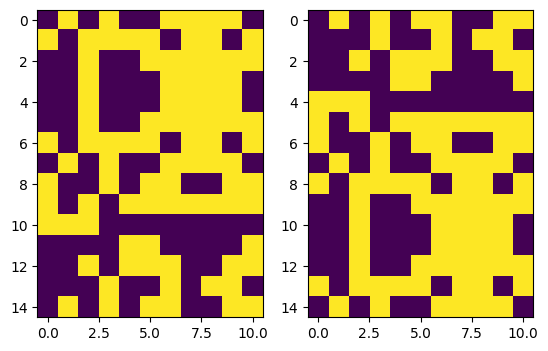

In [36]:
# visualize some
i = 10# 2 has vertical symmetry, 7 horizontal
plt.subplot(1,2,1)
plt.imshow(blocks[i]);
plt.subplot(1,2,2)
plt.imshow(np.flip(blocks[i], axis = 0)); # axis 1 is horizontal flip, 0 is vertical

In [76]:
print([block.shape for block in blocks]) #how odd, the shapes are always odd

[(13, 9), (13, 13), (9, 17), (15, 13), (7, 9), (15, 9), (15, 11), (15, 15), (13, 15), (9, 15), (15, 11), (15, 17), (11, 15), (17, 13), (15, 13), (15, 7), (17, 11), (17, 11), (13, 17), (17, 11), (11, 11), (13, 11), (11, 13), (17, 17), (9, 13), (15, 7), (13, 17), (11, 15), (7, 17), (11, 9), (7, 7), (13, 17), (17, 7), (11, 11), (13, 13), (11, 13), (15, 9), (11, 15), (9, 11), (15, 13), (9, 7), (13, 7), (13, 9), (9, 9), (9, 13), (13, 7), (17, 17), (13, 17), (7, 15), (7, 15), (15, 13), (15, 7), (15, 11), (13, 9), (15, 17), (13, 17), (9, 9), (15, 7), (17, 13), (15, 9), (13, 11), (9, 11), (11, 13), (17, 11), (7, 15), (17, 17), (17, 11), (9, 17), (9, 15), (17, 13), (17, 11), (11, 17), (15, 11), (9, 17), (11, 17), (7, 11), (7, 17), (7, 7), (17, 17), (17, 17), (17, 15), (9, 17), (7, 9), (7, 11), (7, 15), (17, 13), (17, 11), (17, 17), (15, 15), (11, 7), (11, 17), (11, 11), (11, 7), (9, 13), (13, 9), (11, 13), (11, 9), (7, 13), (15, 13), (15, 13)]


In [7]:

def split_block(block):
    """
    Input is 1 block. Block is np.array of 1 and 0 converted from # and .
    It splits the array on each row into two equal parts and remainder
    , mirrors one of the parts and asserts if they are reflecitons.
    """
    pass

answer = 0

# how many per block? # actually 1 per block interestingly
for i in range(len(blocks)):
    # first go from top to the middle
    nrow = blocks[i].shape[0]
    ncol = blocks[i].shape[1]
    # we go by rows first and then by cols
    # start with 1 since no need for 0-size arrays
    for j in range(1, nrow):
        # if we are in the first half slice like this:
        if j < nrow/2:
            # arrays are part1, part2 and remainder
            p1,p2,r = np.split(blocks[i], [j, j*2], axis=0)
            # check is p2 is mirror of p1
            # if it is true, the number of lines above it is exactly j and we need j*100
            if np.array_equal(p1, np.flip(p2, axis = 0)):
                answer += j*100 # 1 to count Trues
        else:
            # now remainder is on top and we compare bottom halves
            r,p1,p2 = np.split(blocks[i], [j-(nrow-j), j ], axis=0)
            if np.array_equal(p1, np.flip(p2, axis = 0)):
                answer += j*100
    # now go by cols
    for j in range(1, ncol):
        if j < ncol/2:
            # arrays are part1, part2 and remainder now left to right
            p1,p2,r = np.split(blocks[i], [j, j*2], axis=1)
            # we nee dnum cols to the left which is again just j (they did it on purpose I guess)
            if np.array_equal(p1, np.flip(p2, axis = 1)):
                answer += j
        else:
            # now remainder is on left and we compare right halves
            r,p1,p2 = np.split(blocks[i], [j-(ncol-j), j ], axis=1)
            if np.array_equal(p1, np.flip(p2, axis = 1)):
                answer += j

print(answer)

32035


In [ ]:
# first slide a divider line along the array (e.g. top to bottom for axis 0) till half length (2 equal arrays)
# ! handle constraint - what if we have odd number of rows?
# assert equal array after np.flip the lesser half to find mirrors
#
# then repeat along the other axis

#def read_data(file):

#def find_mirror(block):


In [51]:
# maybe try string methods first
#def horizontal_mirror:
    # find two of the same string
    # run in two oposing directions
    # return length

### day 14



--- Day 14: Parabolic Reflector Dish ---

You reach the place where all of the mirrors were pointing: a massive parabolic reflector dish attached to the side of another large mountain.

The dish is made up of many small mirrors, but while the mirrors themselves are roughly in the shape of a parabolic reflector dish, each individual mirror seems to be pointing in slightly the wrong direction. If the dish is meant to focus light, all it's doing right now is sending it in a vague direction.

This system must be what provides the energy for the lava! If you focus the reflector dish, maybe you can go where it's pointing and use the light to fix the lava production.

Upon closer inspection, the individual mirrors each appear to be connected via an elaborate system of ropes and pulleys to a large metal platform below the dish. The platform is covered in large rocks of various shapes. Depending on their position, the weight of the rocks deforms the platform, and the shape of the platform controls which ropes move and ultimately the focus of the dish.

In short: if you move the rocks, you can focus the dish. The platform even has a control panel on the side that lets you tilt it in one of four directions! The rounded rocks (O) will roll when the platform is tilted, while the cube-shaped rocks (#) will stay in place. You note the positions of all of the empty spaces (.) and rocks (your puzzle input). For example:

```
O....#....
O.OO#....#
.....##...
OO.#O....O
.O.....O#.
O.#..O.#.#
..O..#O..O
.......O..
#....###..
#OO..#....
```

Start by tilting the lever so all of the rocks will slide north as far as they will go:

```
OOOO.#.O..
OO..#....#
OO..O##..O
O..#.OO...
........#.
..#....#.#
..O..#.O.O
..O.......
#....###..
#....#....
```

You notice that the support beams along the north side of the platform are damaged; to ensure the platform doesn't collapse, you should calculate the total load on the north support beams.

The amount of load caused by a single rounded rock (O) is equal to the number of rows from the rock to the south edge of the platform, including the row the rock is on. (Cube-shaped rocks (#) don't contribute to load.) So, the amount of load caused by each rock in each row is as follows:

```
OOOO.#.O.. 10
OO..#....#  9
OO..O##..O  8
O..#.OO...  7
........#.  6
..#....#.#  5
..O..#.O.O  4
..O.......  3
#....###..  2
#....#....  1
```

The total load is the sum of the load caused by all of the rounded rocks. In this example, the total load is 136.

Tilt the platform so that the rounded rocks all roll north. Afterward, what is the total load on the north support beams?


In [ ]:
# tempted to solve wiht np arrays again
# 1. rule to slide everything up
# 2. enumerate and sum up (can be even done on string level)

In [19]:
# easy string replacement
def replace_str(input_string, i, replacement='O'):
    """ replace any char in string at given index"""
    return input_string[:i] + replacement + input_string[i+1:]

# this just moves them by one
def move_north(i,j,inp):
    res = inp.copy() # do not overwrite original
    curr_stone = res[j][i]
    above_stone = res[j-1][i]
    if curr_stone=='O' and above_stone=='.':
        res[j-1] = replace_str(res[j-1], i ,'O')
        res[j] = replace_str(res[j], i ,'.')
    return res


In [20]:
# load input
with open('input_14', 'r') as f:
    inp = f.read().splitlines()

In [21]:
inp

['O....#.O.#.O...O.O....#.#O....#.#..OO##.......#...O..O......O.OO.OOO.#...##...O...O#O....O..O#......',
 '.....#.....O....O...##OOO#O.O..O..#...OO.#O#.#.O....O#...O##O.........##.........#.....O..O..O...OOO',
 '...#OO#..#...#..O#.#......#.O......#.........O.#...O##....#.#..O..##..O...#......O.O.......##.#O.OO.',
 'OO..##.#...O..O.OO#..#.#...O.O....OO.O.O.O......O#..#O...#.O.....#...........O.....O##..O.#..OO..O..',
 '..O...O.....O..#O.O.....##..#..#..O......#..#.#.O.O#....##.O..O#....#..#....#.##O..#.O..OOO....O.#.#',
 '#..O.OO.....#...#..O...#..O##..O#..O.....O...O..#.#...O.#..O.....OO...##.O.O....#..O..O...#....OO...',
 '......O..O...#.#.....OO.........###O....O..O.##....O#.#.O.#.O.O..#....O.#.O....#.O.O##...O.....#....',
 '..#.O#..O....O...O.O.....#O#.O.OO..#OO..O..#.....#...#.....#.#.##..O##..#.O.O#...O..#.O#OOOO.....O..',
 'O#O.O.O.O.....#......O......O.O..O.OO.O..O#...O.O..OO.O.#.OO.O.#...OO...#.O...O.....#.O##O.....#O#O.',
 '..#.#..O......#....#.#O..O..##OO.....OO.#O.O..O.....#

In [35]:
res = inp.copy()
for l in range(100): #run through input 100 times #while #next res != this res # repeat until convergence
    for j in range(1,100): #move each line up except the first one
        for i in range(100): # for each column
            res = move_north(i, j, res)
res

['OOO.O#.OO#OOO.OOOO....#O#OOOOO#O#..OO##OO.O...#OO.OOOOOO.O..O.OO.OOO.#...##O.OO.O.O#O.OOOOO.O#.OOOOO',
 'O....#..O..O....O...##O.O#..OOO...#.OOOOO#.#.#..O.O..#.O..##O.OO......##.O.......#OO..O.OO...O.OOOO.',
 '...#.O#.O#.O.#..O#.#O.O...#...O...O#OOOO.O.O.O.#....##.O..#O#.O...##..O..O#......O.O..O.OO.##O#O.OO.',
 '...O##O#.O.O....OO#OO#O#..O...O...OO.OO......O...#..#O.O.#.OO.O..#OO.....OO......O..##O..O#O.OO.....',
 '...OOOOO...O...#.OOOOOO.##O.#.O#...O.O...#..#.#....#...O##.O..O#.OOO#..#.OO.#.##.O.#.OO..OOO.....#.#',
 '#...O.OO....#...#.O.OOO#O..##.OO#..O.O...O..O...#.#O...O#.....O...OO..##.OO.O.O.#O.O..O..O#O.....O..',
 'O.....O.....O#.#O...O..O....O..O###..O...O...##.O..O#.#.O.#......#OO..OO#.O.O.O#OO.O##O..OOO...#....',
 'O.#..#.......O.OO...O....#.#...OOO.#.....O.#.OO.O#.OO#O...O#.#.##O..##OO#.O.O#.OO...#.O#...O........',
 '.#O...........#..........O......O..O.....O#O.OO.O..O.O..#.OO.O.#OO..O.O.#.O.O.......#.O##......#.#..',
 '.O#.#.........#....#.#......##..........#OO..OO.O..O#

In [36]:
values = list(range(len(res),0,-1))
#values

In [37]:
# enumerate and count
weights = [row.count('O') for row in res]
#weights

In [38]:
np.sum([w*v for w,v in zip(weights, values)]) # 106990 right answer

106990

In [ ]:
##### recursion -- not working -- #######

# 1. move all 0 as far as they go
# start with the last string in the list
# if there are 0s: for each 0:
# if n-1 string has . in the same index, swap them
# do recursively until stop or end reached
# if # or 0 move to next 0

# it seems to be a square matrix
#if len(inp) == len(inp[0]):
#    m=len(inp[0])
#else:
#    raise(Exception('check input matrix dimensions'))


# move up (element i to one up #(not to top of input)
# acocunting for other elements on the way and moving them together
# should be recursive (or just check all elements up to top)
#def move_north(i, j , inp=inp):
#    #j = len(inp)
#
#    res = inp.copy()
#
#
#    #element = res[j][i] # i-th element in j-th string (starting last string at the bottom)
#
#    # break condiitons: cannot move
#    if j==0 or element!='O':
#        return inp
#    else:
#        #if element=='O': # round we can move up
#        if res[j-1][i]=='#': #block
#            print('square stone, cannot move..')
#            return inp
#        if res[j-1][i]=='.': # check if position above is free
#            print('space free, moving current stone...')
#            res[j-1] = replace_str(res[j-1],i,'O') #replace in str above (screw strings are immutable)
#            res[j] = replace_str(res[j],i,'.') # and below
#            return move_north(i,j-1,res) # move up as much as it goes
#        ## it works up until here, the trick is to move many stones...
#        if res[j-1][i]=='O': # if above one is a stone
            # start building a block of stones that will move together


            # current failed recursion
#            print('no space, moving the above stone...')
#            print(i, j)
#            return move_north(i, j, move_north(i, j-1, res))

            # record j to come back to it
#            j_bk = j
#            # we need to move all of them at the same time
#            res2 = move_north(i, j-1, res) # move the blocking stone up
#            #return res2 #this works
#            #return move_north(i, j, move_north(i, j-1, res)) # this does not
#            print('now moving current stone ...')
#            print(i,j) # apparently we need to reset the j again of course
#            return(move_north(i,j_bk,res2))

# loop over string indices in the last string
#for i in range(m):
    #for j in range(m-1,0,-1): # counting backwards for strings in the list, excluding the last
    #move_north(i)

### day 15

--- Day 15: Lens Library ---

The newly-focused parabolic reflector dish is sending all of the collected light to a point on the side of yet another mountain - the largest mountain on Lava Island. As you approach the mountain, you find that the light is being collected by the wall of a large facility embedded in the mountainside.

You find a door under a large sign that says "Lava Production Facility" and next to a smaller sign that says "Danger - Personal Protective Equipment required beyond this point".

As you step inside, you are immediately greeted by a somewhat panicked reindeer wearing goggles and a loose-fitting hard hat. The reindeer leads you to a shelf of goggles and hard hats (you quickly find some that fit) and then further into the facility. At one point, you pass a button with a faint snout mark and the label "PUSH FOR HELP". No wonder you were loaded into that trebuchet so quickly!

You pass through a final set of doors surrounded with even more warning signs and into what must be the room that collects all of the light from outside. As you admire the large assortment of lenses available to further focus the light, the reindeer brings you a book titled "Initialization Manual".

"Hello!", the book cheerfully begins, apparently unaware of the concerned reindeer reading over your shoulder. "This procedure will let you bring the Lava Production Facility online - all without burning or melting anything unintended!"

"Before you begin, please be prepared to use the Holiday ASCII String Helper algorithm (appendix 1A)." You turn to appendix 1A. The reindeer leans closer with interest.

The HASH algorithm is a way to turn any string of characters into a single number in the range 0 to 255. To run the HASH algorithm on a string, start with a current value of 0. Then, for each character in the string starting from the beginning:

    Determine the ASCII code for the current character of the string.
    Increase the current value by the ASCII code you just determined.
    Set the current value to itself multiplied by 17.
    Set the current value to the remainder of dividing itself by 256.

After following these steps for each character in the string in order, the current value is the output of the HASH algorithm.

So, to find the result of running the HASH algorithm on the string HASH:

    The current value starts at 0.
    The first character is H; its ASCII code is 72.
    The current value increases to 72.
    The current value is multiplied by 17 to become 1224.
    The current value becomes 200 (the remainder of 1224 divided by 256).
    The next character is A; its ASCII code is 65.
    The current value increases to 265.
    The current value is multiplied by 17 to become 4505.
    The current value becomes 153 (the remainder of 4505 divided by 256).
    The next character is S; its ASCII code is 83.
    The current value increases to 236.
    The current value is multiplied by 17 to become 4012.
    The current value becomes 172 (the remainder of 4012 divided by 256).
    The next character is H; its ASCII code is 72.
    The current value increases to 244.
    The current value is multiplied by 17 to become 4148.
    The current value becomes 52 (the remainder of 4148 divided by 256).

So, the result of running the HASH algorithm on the string HASH is 52.

The initialization sequence (your puzzle input) is a comma-separated list of steps to start the Lava Production Facility. Ignore newline characters when parsing the initialization sequence. To verify that your HASH algorithm is working, the book offers the sum of the result of running the HASH algorithm on each step in the initialization sequence.

For example:

rn=1,cm-,qp=3,cm=2,qp-,pc=4,ot=9,ab=5,pc-,pc=6,ot=7

This initialization sequence specifies 11 individual steps; the result of running the HASH algorithm on each of the steps is as follows:

    rn=1 becomes 30.
    cm- becomes 253.
    qp=3 becomes 97.
    cm=2 becomes 47.
    qp- becomes 14.
    pc=4 becomes 180.
    ot=9 becomes 9.
    ab=5 becomes 197.
    pc- becomes 48.
    pc=6 becomes 214.
    ot=7 becomes 231.

In this example, the sum of these results is 1320. Unfortunately, the reindeer has stolen the page containing the expected verification number and is currently running around the facility with it excitedly.

Run the HASH algorithm on each step in the initialization sequence. What is the sum of the results? (The initialization sequence is one long line; be careful when copy-pasting it.)


In [63]:
# function ord() will get the ascii code of the character
ord('r')

114

In [79]:
#ex = 'rn=1,cm-,qp=3,cm=2,qp-,pc=4,ot=9,ab=5,pc-,pc=6,ot=7'
with open('input_15','r') as f:
    inp=f.read().strip()
l = [[ord(char) for char in list(step)] for step in inp.split(',')]
inp

'slsv=7,bc=9,kbp-,cfr=3,slxgsf=7,bz=1,nbp-,svj=4,nbp=9,dz=7,mmqm=4,xjs=6,kdvhk=6,lgt-,gc-,sdjv=8,jfpvgt=5,zm=2,hbpmm-,pvb=9,bs-,dpj=4,vcp-,tvv-,pr-,bmx=9,mdc=2,pmpv=9,gdfgc-,krn=1,hpk=4,bcdsz-,pj-,vhlkz-,kcg=4,fxnk-,vvv-,cfr-,hbpmm=5,gr=8,lks=3,nqrdmh-,xksq-,zv=6,qpl-,lc-,ssnbtj-,cbslp=5,vhsd-,dkt=1,vg=7,cvd=2,vq=1,kjkt-,rrdkm-,dtsx-,slhkm=7,gc-,zk-,fdkfc-,lr-,pmpv-,mzzg=6,zpplm-,qmft-,dlrz-,xbrg-,vg=7,lp=6,fmg=7,jrb-,rjz=6,jnmz-,qlf=9,kfk-,hcsbqm-,bc=5,ll-,xczgt-,hn=9,lmfg=4,mgx=6,dvm-,qbvx-,zll-,lnl-,bs-,xdl=7,fl=7,bzxr-,prz-,nbp-,vpl=4,ppxtq-,mr=7,xdzch=5,gh=5,qdk-,crzsnh-,phc-,szgp=2,cmsg=2,jgxj-,tpqd-,bbh=1,hn-,ljm=4,pfdjc-,rsnr-,kbp=3,xxv-,fsrk-,nqrdmh-,cbj-,zctgz-,vs-,cmsg=5,pmv-,zm-,vvv=3,mj=5,vjzc-,xl-,mbz=8,jd-,dqrf-,gl-,zngc-,qj-,fg-,qt-,bz=9,nvc=3,pvb-,qz=2,pnxx=4,cjj=7,chc-,mzzg=3,fmg=1,hbpmm-,jj=7,hrppv=8,hkgz=2,sfp-,tvv-,zmqld-,nbk-,lp=3,rx-,srf=1,mf-,xhqm=1,vc=2,gdcv=8,rn=6,bs=1,kj-,rsnr=8,dvf-,dq-,knvm-,szqz=9,lrrt=3,fvbcj=6,qvd=1,qp=5,mht=1,dz=4,nvc=7,cbslp-,xs-,ln=2,

In [80]:
values = []
# HASH has to be run on each string separately
for entry in l:
    current_value = 0
    for ascii in entry:
        current_value += ascii
        current_value = current_value*17
        current_value = current_value%256
    values.append(current_value)


In [81]:
sum(values) #507317 is too high OK I forgot to strip \n

507291

--- Part Two ---

You convince the reindeer to bring you the page; the page confirms that your HASH algorithm is working.

The book goes on to describe a series of 256 boxes numbered 0 through 255. The boxes are arranged in a line starting from the point where light enters the facility. The boxes have holes that allow light to pass from one box to the next all the way down the line.

```
      +-----+  +-----+         +-----+
Light | Box |  | Box |   ...   | Box |
----------------------------------------->
      |  0  |  |  1  |   ...   | 255 |
      +-----+  +-----+         +-----+
```

Inside each box, there are several lens slots that will keep a lens correctly positioned to focus light passing through the box. The side of each box has a panel that opens to allow you to insert or remove lenses as necessary.

Along the wall running parallel to the boxes is a large library containing lenses organized by focal length ranging from 1 through 9. The reindeer also brings you a small handheld label printer.

The book goes on to explain how to perform each step in the initialization sequence, a process it calls the Holiday ASCII String Helper Manual Arrangement Procedure, or HASHMAP for short.

Each step begins with a sequence of letters that indicate the label of the lens on which the step operates. The result of running the HASH algorithm on the label indicates the correct box for that step.

The label will be immediately followed by a character that indicates the operation to perform: either an equals sign (=) or a dash (-).

If the operation character is a dash (-), go to the relevant box and remove the lens with the given label if it is present in the box. Then, move any remaining lenses as far forward in the box as they can go without changing their order, filling any space made by removing the indicated lens. (If no lens in that box has the given label, nothing happens.)

If the operation character is an equals sign (=), it will be followed by a number indicating the focal length of the lens that needs to go into the relevant box; be sure to use the label maker to mark the lens with the label given in the beginning of the step so you can find it later. There are two possible situations:

    If there is already a lens in the box with the same label, replace the old lens with the new lens: remove the old lens and put the new lens in its place, not moving any other lenses in the box.
    If there is not already a lens in the box with the same label, add the lens to the box immediately behind any lenses already in the box. Don't move any of the other lenses when you do this. If there aren't any lenses in the box, the new lens goes all the way to the front of the box.

Here is the contents of every box after each step in the example initialization sequence above:

After "rn=1":
Box 0: [rn 1]

After "cm-":
Box 0: [rn 1]

After "qp=3":
Box 0: [rn 1]
Box 1: [qp 3]

After "cm=2":
Box 0: [rn 1] [cm 2]
Box 1: [qp 3]

After "qp-":
Box 0: [rn 1] [cm 2]

After "pc=4":
Box 0: [rn 1] [cm 2]
Box 3: [pc 4]

After "ot=9":
Box 0: [rn 1] [cm 2]
Box 3: [pc 4] [ot 9]

After "ab=5":
Box 0: [rn 1] [cm 2]
Box 3: [pc 4] [ot 9] [ab 5]

After "pc-":
Box 0: [rn 1] [cm 2]
Box 3: [ot 9] [ab 5]

After "pc=6":
Box 0: [rn 1] [cm 2]
Box 3: [ot 9] [ab 5] [pc 6]

After "ot=7":
Box 0: [rn 1] [cm 2]
Box 3: [ot 7] [ab 5] [pc 6]

All 256 boxes are always present; only the boxes that contain any lenses are shown here. Within each box, lenses are listed from front to back; each lens is shown as its label and focal length in square brackets.

To confirm that all of the lenses are installed correctly, add up the focusing power of all of the lenses. The focusing power of a single lens is the result of multiplying together:

    One plus the box number of the lens in question.
    The slot number of the lens within the box: 1 for the first lens, 2 for the second lens, and so on.
    The focal length of the lens.

At the end of the above example, the focusing power of each lens is as follows:

    rn: 1 (box 0) * 1 (first slot) * 1 (focal length) = 1
    cm: 1 (box 0) * 2 (second slot) * 2 (focal length) = 4
    ot: 4 (box 3) * 1 (first slot) * 7 (focal length) = 28
    ab: 4 (box 3) * 2 (second slot) * 5 (focal length) = 40
    pc: 4 (box 3) * 3 (third slot) * 6 (focal length) = 72

So, the above example ends up with a total focusing power of 145.

With the help of an over-enthusiastic reindeer in a hard hat, follow the initialization sequence. What is the focusing power of the resulting lens configuration?


In [82]:
def hash(entry: str):
    l=[ord(char) for char in list(entry)]#string to list of ascii
    current_value=0
    for ascii in l:
        current_value += ascii
        current_value = current_value*17
        current_value = current_value%256
    return current_value


In [85]:
hash('qp') # hash on box label gives box id 0 to 255

1

### day 16

--- Day 16: The Floor Will Be Lava ---

With the beam of light completely focused somewhere, the reindeer leads you deeper still into the Lava Production Facility. At some point, you realize that the steel facility walls have been replaced with cave, and the doorways are just cave, and the floor is cave, and you're pretty sure this is actually just a giant cave.

Finally, as you approach what must be the heart of the mountain, you see a bright light in a cavern up ahead. There, you discover that the beam of light you so carefully focused is emerging from the cavern wall closest to the facility and pouring all of its energy into a contraption on the opposite side.

Upon closer inspection, the contraption appears to be a flat, two-dimensional square grid containing empty space (.), mirrors (/ and \), and splitters (| and -).

The contraption is aligned so that most of the beam bounces around the grid, but each tile on the grid converts some of the beam's light into heat to melt the rock in the cavern.

You note the layout of the contraption (your puzzle input). For example:

```
.|...\....
|.-.\.....
.....|-...
........|.
..........
.........\
..../.\\..
.-.-/..|..
.|....-|.\
..//.|....
```

The beam enters in the top-left corner from the left and heading to the right. Then, its behavior depends on what it encounters as it moves:

    If the beam encounters empty space (.), it continues in the same direction.
    If the beam encounters a mirror (/ or \), the beam is reflected 90 degrees depending on the angle of the mirror. For instance, a rightward-moving beam that encounters a / mirror would continue upward in the mirror's column, while a rightward-moving beam that encounters a \ mirror would continue downward from the mirror's column.
    If the beam encounters the pointy end of a splitter (| or -), the beam passes through the splitter as if the splitter were empty space. For instance, a rightward-moving beam that encounters a - splitter would continue in the same direction.
    If the beam encounters the flat side of a splitter (| or -), the beam is split into two beams going in each of the two directions the splitter's pointy ends are pointing. For instance, a rightward-moving beam that encounters a | splitter would split into two beams: one that continues upward from the splitter's column and one that continues downward from the splitter's column.

Beams do not interact with other beams; a tile can have many beams passing through it at the same time. A tile is energized if that tile has at least one beam pass through it, reflect in it, or split in it.

In the above example, here is how the beam of light bounces around the contraption:

```
>|<<<\....
|v-.\^....
.v...|->>>
.v...v^.|.
.v...v^...
.v...v^..\
.v../2\\..
<->-/vv|..
.|<<<2-|.\
.v//.|.v..
```

Beams are only shown on empty tiles; arrows indicate the direction of the beams. If a tile contains beams moving in multiple directions, the number of distinct directions is shown instead. Here is the same diagram but instead only showing whether a tile is energized (#) or not (.):

```
######....
.#...#....
.#...#####
.#...##...
.#...##...
.#...##...
.#..####..
########..
.#######..
.#...#.#..
```

Ultimately, in this example, 46 tiles become energized.

The light isn't energizing enough tiles to produce lava; to debug the contraption, you need to start by analyzing the current situation. With the beam starting in the top-left heading right, how many tiles end up being energized?


In [ ]:
# matrix as object
class InputMatrix:
    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            self.mat = f.read().splitlines()

In [4]:
# clean up
# this loop does not work as list shortens with every deletion and we get index error!
# it works if we chop off from the end of the list
# unfortunatel del beam in list comprehenison does nothing
def clean_up(mybeam):
    """ removes all Beams """
    print(f'there are {len(mybeam.all_instances)} beams')
    for i in range(len(mybeam.all_instances)-1, -1, -1):
        print(f'deleting {mybeam.all_instances[i].exists} beam at {mybeam.all_instances[i].coord}')
        del mybeam.all_instances[i]
    print(f'now there are {len(mybeam.all_instances)} beams')

In [28]:
with open('input_16_example', 'r') as f:
    inp = f.read().splitlines()
inp

['.|...\\....',
 '|.-.\\.....',
 '.....|-...',
 '........|.',
 '..........',
 '.........\\',
 '..../.\\\\..',
 '.-.-/..|..',
 '.|....-|.\\',
 '..//.|....']

In [115]:
class Beam:
    """
    It has current position and also methods to move it.
    It lives in the space of the given input
    """

    # list to keep track of split beams
    all_instances = []

    # class attr
    # helper to flip axes and directions
    flip_dict={0:1, 1:0, '+':'-', '-':'+'}

    # we start at the top left moving right horizontally
    def __init__(self, coord=[0,0],ax=1,direction='+',inp=inp):
        self.coord=coord#[0,0]
        self.check() #kill right away if coordinates are negative
        self.ax=ax#1
        self.direction=direction#'+'
        # set current character which defines where we move
        self.char=inp[self.coord[0]][self.coord[1]]
        # array mask recording how beam moved
        self.mask = np.zeros((len(inp),len(inp[0])), dtype=bool)
        self.mask[tuple(self.coord)]=True #first one is always T
        self.exists = True #will turn to F if it goes off the edge
        # add to the list to keep track after splitting beams
        self.all_instances.append(self)
        # counter to avoid infinite loops
        # will activate if beam goes on energized path
        self.counter = 0
        # record secondary beams generated on split
        self.secondary = []

    def main(self):
        return f'beam at {self.coord}'

    def check(self):
        """Checks if coordinates are over the edge"""
        if (self.coord[0] < 0) or \
            (self.coord[0] >= len(inp[0])) or \
                (self.coord[1] < 0) or \
                    (self.coord[0] >= len(inp)): #if I have 10 lines last index is 9
                        self.exists=False


    def split(self):
        """
        Records beam properties at the split position flipping direction
        """
        self.secondary.append({'coord':self.coord.copy() #be ware to create a copy, otherwise this gets updated to the last coord!
                                   ,'ax': self.ax
                                   ,'direction':Beam.flip_dict[self.direction]})


    def update_coord(self):
        self.coord[self.ax] = eval(str(self.coord[self.ax])+self.direction+'1')
        self.check()
        # update char and mask only if beam exists
        if self.exists:
            self.char=inp[self.coord[0]][self.coord[1]]
            # if the coord is already energized, activate counter
            if self.mask[tuple(self.coord)]:
                self.counter += 1
                # kill the beam if it only goes threaded path with some tolerance
                if self.counter>100:
                    self.exists=False
            else:
                self.mask[tuple(self.coord)]=True
        print(f'exists: {self.exists}')
        return self


    # if we move we overwrite the coordinate
    def move(self):
        # first update ax and direction depending on self.char
        # then update coord after move accordingly
        # also update current char
        # possible chars '.|-\/'

        # case: goes straight on
        if (self.char == '.') or \
            (self.char == '-' and self.ax == 1) or \
                (self.char == '|' and self.ax == 0):
                    self.update_coord()
        # case: deflects 90 degrees
        elif self.char == '/':
            # it will flip axis and direction
            self.ax = Beam.flip_dict[self.ax]
            self.direction = Beam.flip_dict[self.direction]
            self.update_coord()
        elif self.char == '\\':
            # it will flip axis
            self.ax = Beam.flip_dict[self.ax]
            self.update_coord()

        # case: split beam
        elif (self.char == '-' and self.ax == 0) or \
            (self.char == '|' and self.ax == 1):
            # this is actually a combination of \ and /
            self.ax = Beam.flip_dict[self.ax]
            print(f'beam at {self.coord} split')
            self.split()
            print(f'secondary beams: {self.secondary}')
            self.update_coord()

        print(f'new coordinates: {self.coord}, new char: {self.char}')
        return self


In [116]:
if 'mybeam' in globals():
    clean_up(mybeam)
if 'newbeam' in globals():
    clean_up(newbeam) # all secondary beams will go there - it is the latest in the loop

there are 5 beams
deleting False beam at [-1, 1]
deleting False beam at [7, -1]
deleting False beam at [7, -1]
deleting False beam at [-1, 1]
deleting False beam at [10, 7]
now there are 0 beams
there are 0 beams
now there are 0 beams


In [117]:
inp

['.|...\\....',
 '|.-.\\.....',
 '.....|-...',
 '........|.',
 '..........',
 '.........\\',
 '..../.\\\\..',
 '.-.-/..|..',
 '.|....-|.\\',
 '..//.|....']

In [118]:
# iteration 1
# external secondary beams records
mybeam = Beam(inp=inp)
#print(mybeam.main())
secondary = []
while mybeam.exists:
    mybeam.move()
secondary.extend(mybeam.secondary)

exists: True
new coordinates: [0, 1], new char: |
beam at [0, 1] split
secondary beams: [{'coord': [0, 1], 'ax': 0, 'direction': '-'}]
exists: True
new coordinates: [1, 1], new char: .
exists: True
new coordinates: [2, 1], new char: .
exists: True
new coordinates: [3, 1], new char: .
exists: True
new coordinates: [4, 1], new char: .
exists: True
new coordinates: [5, 1], new char: .
exists: True
new coordinates: [6, 1], new char: .
exists: True
new coordinates: [7, 1], new char: -
beam at [7, 1] split
secondary beams: [{'coord': [0, 1], 'ax': 0, 'direction': '-'}, {'coord': [7, 1], 'ax': 1, 'direction': '-'}]
exists: True
new coordinates: [7, 2], new char: .
exists: True
new coordinates: [7, 3], new char: -
exists: True
new coordinates: [7, 4], new char: /
exists: True
new coordinates: [6, 4], new char: /
exists: True
new coordinates: [6, 5], new char: .
exists: True
new coordinates: [6, 6], new char: \
exists: True
new coordinates: [7, 6], new char: .
exists: True
new coordinates: [8, 

In [119]:
secondary

[{'coord': [0, 1], 'ax': 0, 'direction': '-'},
 {'coord': [7, 1], 'ax': 1, 'direction': '-'},
 {'coord': [8, 6], 'ax': 1, 'direction': '-'},
 {'coord': [8, 7], 'ax': 0, 'direction': '-'}]

In [120]:
# initiate secondary beams
# record their secondaries in a separate thing
def process(record):

#for record in mybeam.secondary:
    newbeam = Beam(record['coord']
               , record['ax']
               , record['direction']
               , inp)
    print(f'initiated {newbeam.main()}')
    while newbeam.exists:
        newbeam.move()
    # return this to replace the original record with its secondary!
    #secondary.extend(newbeam.secondary)
    return newbeam.secondary

In [113]:
secondary=[process(record) for record in secondary] #this is a clean list of new beams!
#secondary = [item for sublist in regular_list for item in sublist]

initiated beam at [0, 1]
exists: False
new coordinates: [-1, 1], new char: |
initiated beam at [7, 1]
exists: True
new coordinates: [7, 0], new char: .
exists: False
new coordinates: [7, -1], new char: .
initiated beam at [8, 6]
exists: True
new coordinates: [8, 5], new char: .
exists: True
new coordinates: [8, 4], new char: .
exists: True
new coordinates: [8, 3], new char: .
exists: True
new coordinates: [8, 2], new char: .
exists: True
new coordinates: [8, 1], new char: |
beam at [8, 1] split
secondary beams: [{'coord': [8, 1], 'ax': 0, 'direction': '+'}]
exists: True
new coordinates: [7, 1], new char: -
beam at [7, 1] split
secondary beams: [{'coord': [8, 1], 'ax': 0, 'direction': '+'}, {'coord': [7, 1], 'ax': 1, 'direction': '+'}]
exists: True
new coordinates: [7, 0], new char: .
exists: False
new coordinates: [7, -1], new char: .
initiated beam at [8, 7]
exists: True
new coordinates: [7, 7], new char: |
exists: True
new coordinates: [6, 7], new char: \
exists: True
new coordinates

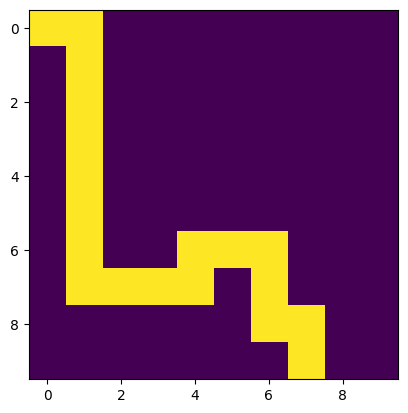

In [ ]:
# collect overlap of all masks
global_mask = np.zeros((len(inp),len(inp[0])),dtype=bool)
for a in [b.mask for b in mybeam.all_instances]: #it will keep record of all anyways
    global_mask = global_mask+a
plt.imshow(global_mask);

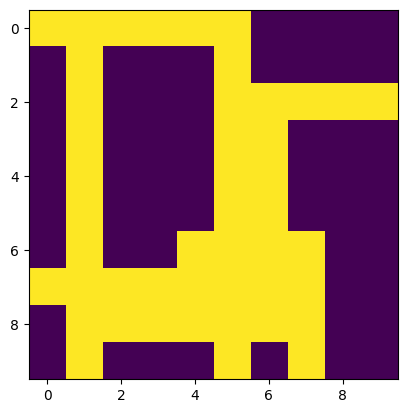

In [99]:
# goal
with open('input_16_example_mask', 'r') as f:
    mask = [
        [int(char) for char in line.translate(str.maketrans('.#','01'))]
        for line in f.read().splitlines()]
    plt.imshow(np.array(mask));

In [76]:
# check which secondary beams have generated tertiary and repeat until convergence
#existing = [b if b.exists for newbeam.all_instances]
#[b.secondary for b in existing if len(b.secondary)>0]
[b.exists for b in mybeam.all_instances] # this is fine they all ran
# I just need to make sure that I do not reinitiate dead beams
# maybe self delete the first guy from the list somehow
# or check at initiation that coords are valid

[False, False, False, False, False]

In [77]:
mybeam.secondary

[{'coord': [-1, 1], 'ax': 0, 'direction': '-'},
 {'coord': [7, -1], 'ax': 1, 'direction': '-'},
 {'coord': [7, -1], 'ax': 1, 'direction': '-'},
 {'coord': [-1, 1], 'ax': 0, 'direction': '-'}]

In [79]:
[b.secondary for b in mybeam.all_instances]

[[{'coord': [-1, 1], 'ax': 0, 'direction': '-'},
  {'coord': [7, -1], 'ax': 1, 'direction': '-'},
  {'coord': [7, -1], 'ax': 1, 'direction': '-'},
  {'coord': [-1, 1], 'ax': 0, 'direction': '-'}],
 [],
 [],
 [{'coord': [8, 1], 'ax': 0, 'direction': '+'},
  {'coord': [7, 1], 'ax': 1, 'direction': '+'}],
 [{'coord': [2, 6], 'ax': 1, 'direction': '+'},
  {'coord': [2, 5], 'ax': 0, 'direction': '+'},
  {'coord': [0, 1], 'ax': 0, 'direction': '+'}]]

In [91]:
secondary

[{'coord': [10, 1], 'ax': 0, 'direction': '+'},
 {'coord': [10, 7], 'ax': 1, 'direction': '+'},
 {'coord': [2, 10], 'ax': 1, 'direction': '+'},
 {'coord': [2, 5], 'ax': 0, 'direction': '+'},
 {'coord': [0, 1], 'ax': 0, 'direction': '+'},
 {'coord': [8, 6], 'ax': 1, 'direction': '-'},
 {'coord': [8, 7], 'ax': 0, 'direction': '-'}]

In [90]:
# initiate tertiary beams
# because the list continues all the old beams will be initiated
# is not very efficient of course but now they will get killed right away

for record in secondary:
    newbeam = Beam(record['coord']
               , record['ax']
               , record['direction']
               , inp)
    print(f'initiated {newbeam.main()}')
    # delete it from secondary
    #del record #bad idea
    while newbeam.exists:
        newbeam.move()
    secondary.extend(newbeam.secondary)

initiated beam at [8, 1]
exists: True
new coordinates: [9, 1], new char: .
exists: False
new coordinates: [10, 1], new char: .
initiated beam at [7, 1]
exists: True
new coordinates: [7, 2], new char: .
exists: True
new coordinates: [7, 3], new char: -
exists: True
new coordinates: [7, 4], new char: /
exists: True
new coordinates: [6, 4], new char: /
exists: True
new coordinates: [6, 5], new char: .
exists: True
new coordinates: [6, 6], new char: \
exists: True
new coordinates: [7, 6], new char: .
exists: True
new coordinates: [8, 6], new char: -
beam at [8, 6] split
secondary beams: [{'coord': [8, 6], 'ax': 1, 'direction': '-'}]
exists: True
new coordinates: [8, 7], new char: |
beam at [8, 7] split
secondary beams: [{'coord': [8, 6], 'ax': 1, 'direction': '-'}, {'coord': [8, 7], 'ax': 0, 'direction': '-'}]
exists: True
new coordinates: [9, 7], new char: .
exists: False
new coordinates: [10, 7], new char: .
initiated beam at [2, 6]
exists: True
new coordinates: [2, 7], new char: .
exist

IndexError: string index out of range

In [26]:
# move beams until all fall off the edge or counter is 1000
# while any(b.exists for b in mybeam.all_instances):
# there can be loops so just move them until mask is not changing
# but I definitely need more tolerance...
#answer = 0
#new_answer = 1
#counter = 0
#while (new_answer > answer) or (counter < len(inp)):
#    answer = np.sum([b.mask for b in mybeam.all_instances])
#    for b in [b for b in mybeam.all_instances if b.exists]:
#        b.move()
#    new_answer = np.sum([b.mask for b in mybeam.all_instances])
#    print(answer, new_answer, counter)
#    if answer >= new_answer:
#        counter += 1

# iteration 2
# move beams which have been split off
# somehow this does not work because they should have stayed at the place where they split off
for beam in [b for b in mybeam.all_instances if b.exists]:
    print(beam.coord)

[10, 7]
[10, 7]
[10, 7]
[10, 7]


In [17]:
np.sum(mybeam.mask)

19

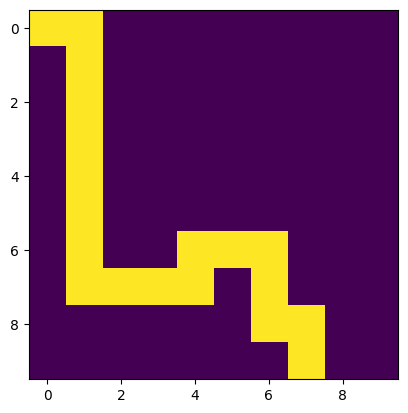

In [18]:
plt.imshow(mybeam.mask);

In [7]:
a = np.zeros((2,2),dtype=bool)
a[0,0] =True
b = np.zeros((2,2),dtype=bool)
b[0,1] =True
c = np.zeros((2,2),dtype=bool)
c[1,1] =True

d = np.zeros((2,2),dtype=bool)
for ar in [a,b,c]:
    d = d+ar
d

array([[ True,  True],
       [False,  True]])

In [8]:
np.sum([a,b,c])

3

In [48]:
len(mybeam.all_instances)

2

In [49]:
[b.exists for b in mybeam.all_instances]

[False, True]

In [72]:
clean_up()

In [ ]:
## olde code

## we go from top left according to the rules
## for each index, we mark True if it is energised
## then count Trues
#
## create input array of Falses
#mask = np.zeros((len(inp),len(inp[0])), dtype=bool)
#
#
## fx to move one step and change params
## I think that requires class Beam and self.coord, self.direction and self.ax
#def move(coord = [0,0], ax=1, direction='+'):
#    coord[ax] = eval(str(coord[ax])+direction+'1') # change the coord dpt on which axis we move on
#    mask[coord]=True #update array
#
##def energize(inp=inp):
#
## start top left going to the right
#coord = [0,0]
#ax = 1 #direction to move (horizontal)
#mask[coord]=True # energize first position
## placeholder for + or - direction
#direction = '+'

#move(coord, ax, direction)

# make rules to move the beam
# first we move one step in current direction
#coord[ax] = eval(str(coord[ax])+direction+'1') # change the coord dpt on which axis we move on
#print(f'new coordinate: {coord}')
# change params accroding to a new value
#new_pos =
# also need to handle what happens after it comes off the edge!
# continue until all beams disappear